In [ ]:
#Librerias Necesarias

In [32]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import psycopg2
import warnings
import os
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)


In [33]:
#Carga de datos

In [34]:
# 2. Carga de datos (muestra equitativa por mes, determinística)
def load_data_from_postgres(years=None, rows_per_year=None):
    """
    Carga datos desde analytics.obt_trips evitando leakage.
    Si se especifica rows_per_year, selecciona un número EQUITATIVO por mes para cada año:
      - per_month = rows_per_year // 12
      - meses 1..(rows_per_year % 12) reciben +1 fila extra
    Selección determinística: se toma 1 fila representativa por cada 'bucket'
    creado con NTILE(...) dentro de (year, month) ordenado por pickup_datetime,
    lo cual esparce los puntos a lo largo del mes SIN aleatoriedad.
    """
    import psycopg2
    import numpy as np
    import os

    PG_HOST = os.getenv("PG_HOST", "localhost")
    PG_PORT = os.getenv("PG_PORT", "5432")
    PG_DB   = os.getenv("PG_DB", "nyc_taxi")
    PG_USER = os.getenv("PG_USER", "postgres")
    PG_PASS = os.getenv("PG_PASSWORD", "postgres")

    conn = psycopg2.connect(host=PG_HOST, port=PG_PORT, database=PG_DB, user=PG_USER, password=PG_PASS)

    base_select = """
    SELECT 
        pickup_datetime,
        EXTRACT(HOUR  FROM pickup_datetime)::int AS pickup_hour,
        EXTRACT(DOW   FROM pickup_datetime)::int AS pickup_dow,
        EXTRACT(MONTH FROM pickup_datetime)::int AS month,
        EXTRACT(YEAR  FROM pickup_datetime)::int AS year,
        pu_location_id, pu_zone, pu_borough,
        service_type, vendor_id, rate_code_id, payment_type, store_and_fwd_flag,
        passenger_count, trip_distance,
        fare_amount, extra, mta_tax, improvement_surcharge,
        congestion_surcharge, airport_fee,
        total_amount
    FROM analytics.obt_trips
    WHERE 
        pickup_datetime IS NOT NULL
        AND trip_distance > 0 AND trip_distance < 100
        AND passenger_count BETWEEN 1 AND 6
        AND total_amount BETWEEN 1 AND 200
        AND fare_amount > 0
    """

    year_filter = ""
    if years:
        years_list = ",".join(str(int(y)) for y in years)
        year_filter = f" AND EXTRACT(YEAR FROM pickup_datetime)::int IN ({years_list})"

    if rows_per_year is None:
        # Sin cupo por año: devuelve todo (filtrado por years si aplica)
        query = f"""
        {base_select}
        {year_filter}
        ORDER BY pickup_datetime;
        """
    else:
        per_month = rows_per_year // 12
        extra     = rows_per_year % 12
        # Meses 1..extra tendrán (per_month + 1) filas; el resto per_month filas.
        # Usamos NTILE( target_mes ) para segmentar cronológicamente el mes en 'target_mes' buckets,
        # y tomamos un representante (rnk=1) de cada bucket → selección esparcida y determinística.
        query = f"""
        WITH base AS (
            {base_select}
            {year_filter}
        ),
        bucketed AS (
            SELECT
                b.*,
                NTILE(
                    CASE 
                        WHEN b.month <= {extra} THEN {per_month + 1}
                        ELSE {per_month}
                    END
                ) OVER (PARTITION BY b.year, b.month ORDER BY b.pickup_datetime) AS bucket_id
            FROM base b
        ),
        picked AS (
            SELECT
                *,
                ROW_NUMBER() OVER (PARTITION BY year, month, bucket_id ORDER BY pickup_datetime) AS rnk
            FROM bucketed
        )
        SELECT *
        FROM picked
        WHERE rnk = 1
        ORDER BY pickup_datetime;
        """

    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

# === USO ===
print("Cargando datos desde Postgres (equitativo por mes)...")
df = load_data_from_postgres(years=[2022, 2023, 2024], rows_per_year=100000)
print(f"Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas")

# Verificación rápida de equidad (deberías ver ~50k por año y repartido por mes)
print("\nConteo por año:")
print(df.groupby('year').size())

print("\nConteo por año-mes:")
print(df.groupby(['year','month']).size().reset_index(name='rows'))


Cargando datos desde Postgres (equitativo por mes)...
Dataset cargado: 300000 filas, 24 columnas

Conteo por año:
year
2022    100000
2023    100000
2024    100000
dtype: int64

Conteo por año-mes:
    year  month  rows
0   2022      1  8334
1   2022      2  8334
2   2022      3  8334
3   2022      4  8334
4   2022      5  8333
5   2022      6  8333
6   2022      7  8333
7   2022      8  8333
8   2022      9  8333
9   2022     10  8333
10  2022     11  8333
11  2022     12  8333
12  2023      1  8334
13  2023      2  8334
14  2023      3  8334
15  2023      4  8334
16  2023      5  8333
17  2023      6  8333
18  2023      7  8333
19  2023      8  8333
20  2023      9  8333
21  2023     10  8333
22  2023     11  8333
23  2023     12  8333
24  2024      1  8334
25  2024      2  8334
26  2024      3  8334
27  2024      4  8334
28  2024      5  8333
29  2024      6  8333
30  2024      7  8333
31  2024      8  8333
32  2024      9  8333
33  2024     10  8333
34  2024     11  8333
35  2024  

## EDA

=== ANÁLISIS EXPLORATORIO DE DATOS ===



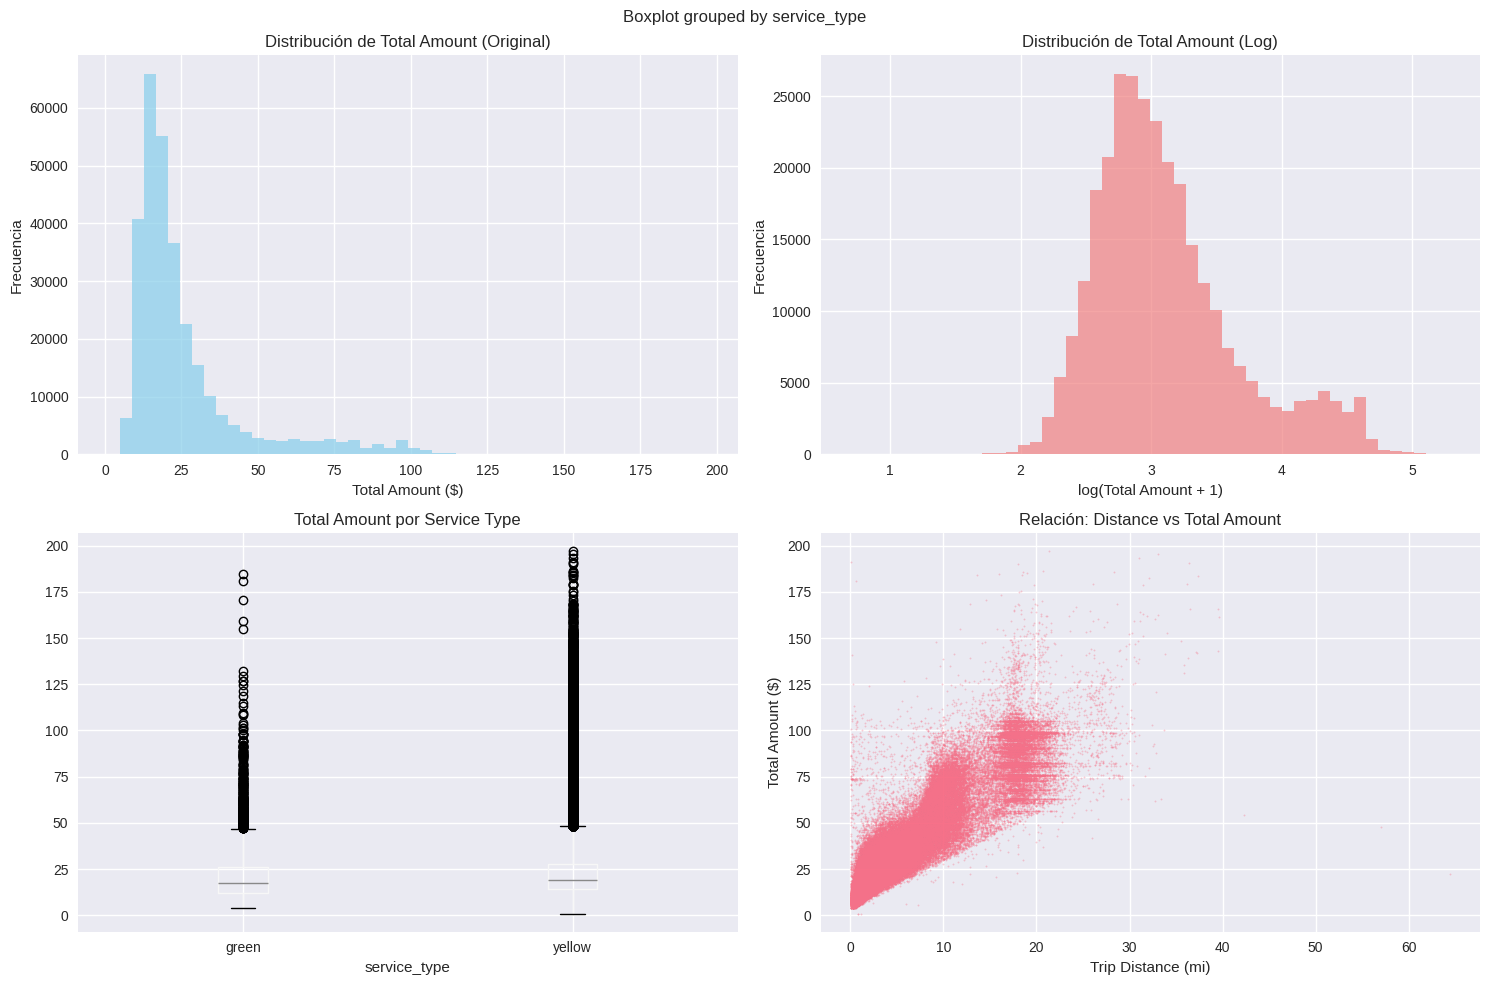

Estadísticas descriptivas del target:
count    300000.000000
mean         25.839168
std          19.665761
min           1.010000
25%          14.300000
50%          19.200000
75%          28.000000
max         197.020000
Name: total_amount, dtype: float64

Cardinalidad de variables categóricas:
service_type: 2 valores únicos
vendor_id: 2 valores únicos
rate_code_id: 6 valores únicos
payment_type: 4 valores únicos
pu_borough: 6 valores únicos
pu_zone: 235 valores únicos
store_and_fwd_flag: 2 valores únicos

Valores nulos por columna:
Series([], dtype: int64)


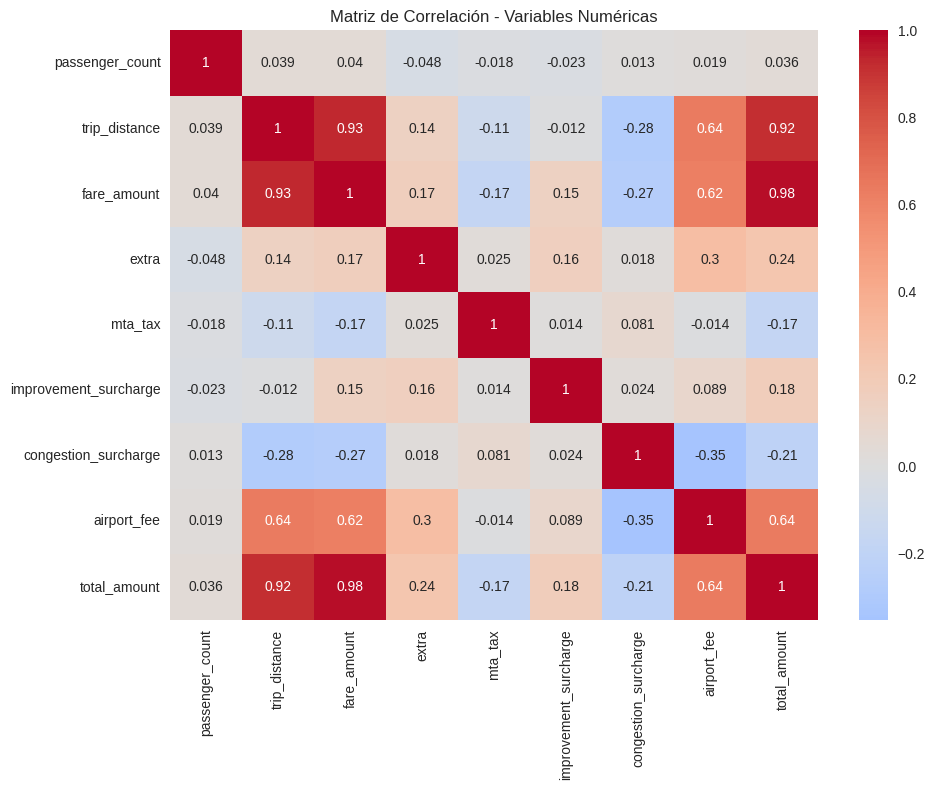

In [35]:
def perform_eda(df):
    """Análisis Exploratorio de Datos"""
    
    print("=== ANÁLISIS EXPLORATORIO DE DATOS ===\n")
    
    # 3.1 Distribución del target
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribución original
    axes[0,0].hist(df['total_amount'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribución de Total Amount (Original)')
    axes[0,0].set_xlabel('Total Amount ($)')
    axes[0,0].set_ylabel('Frecuencia')
    
    # Distribución log (para ver mejor)
    axes[0,1].hist(np.log1p(df['total_amount']), bins=50, alpha=0.7, color='lightcoral')
    axes[0,1].set_title('Distribución de Total Amount (Log)')
    axes[0,1].set_xlabel('log(Total Amount + 1)')
    axes[0,1].set_ylabel('Frecuencia')
    
    # Boxplot por servicio
    df.boxplot(column='total_amount', by='service_type', ax=axes[1,0])
    axes[1,0].set_title('Total Amount por Service Type')
    
    # Relación con trip_distance
    axes[1,1].scatter(df['trip_distance'], df['total_amount'], alpha=0.3, s=1)
    axes[1,1].set_xlabel('Trip Distance (mi)')
    axes[1,1].set_ylabel('Total Amount ($)')
    axes[1,1].set_title('Relación: Distance vs Total Amount')
    
    plt.tight_layout()
    plt.show()
    
    # 3.2 Estadísticas descriptivas
    print("Estadísticas descriptivas del target:")
    print(df['total_amount'].describe())
    
    # 3.3 Cardinalidad de variables categóricas
    print("\nCardinalidad de variables categóricas:")
    categorical_cols = ['service_type', 'vendor_id', 'rate_code_id', 'payment_type', 
                       'pu_borough', 'pu_zone', 'store_and_fwd_flag']
    
    for col in categorical_cols:
        if col in df.columns:
            unique_vals = df[col].nunique()
            print(f"{col}: {unique_vals} valores únicos")
    
    # 3.4 Valores nulos
    print("\nValores nulos por columna:")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0])
    
    # 3.5 Correlaciones numéricas
    numeric_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 
                   'mta_tax', 'improvement_surcharge', 'congestion_surcharge', 
                   'airport_fee', 'total_amount']
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlación - Variables Numéricas')
    plt.tight_layout()
    plt.show()

perform_eda(df)

In [36]:
## Features 

In [37]:
def create_features(df):
    """Crear features finales para el modelo"""
    
    df_processed = df.copy()
    
    # Features temporales derivadas
    df_processed['pickup_hour'] = df_processed['pickup_hour'].astype(int)
    df_processed['pickup_dow'] = df_processed['pickup_dow'].astype(int)
    df_processed['month'] = df_processed['month'].astype(int)
    df_processed['year'] = df_processed['year'].astype(int)
    
    #  Flags derivadas (sin leakage)
    df_processed['is_rush_hour'] = ((df_processed['pickup_hour'] >= 7) & (df_processed['pickup_hour'] <= 9)) | \
                                  ((df_processed['pickup_hour'] >= 17) & (df_processed['pickup_hour'] <= 19))
    
    df_processed['is_weekend'] = df_processed['pickup_dow'].isin([5, 6])
    
    df_processed['is_night'] = (df_processed['pickup_hour'] >= 20) | (df_processed['pickup_hour'] <= 5)
    
    # Transformación de variables categóricas con alta cardinalidad
    # Para pu_zone, usar Top-20 + "Other"
    top_zones = df_processed['pu_zone'].value_counts().head(20).index
    df_processed['pu_zone_processed'] = df_processed['pu_zone'].where(
        df_processed['pu_zone'].isin(top_zones), 'Other'
    )
    
    #  Features de tarifas base (sin leakage)
    df_processed['base_fare_components'] = df_processed['fare_amount'] + df_processed['extra'] + \
                                          df_processed['mta_tax'] + df_processed['improvement_surcharge']
    
    # Definir variables finales
    numeric_features = ['trip_distance', 'passenger_count', 'pickup_hour', 
                       'base_fare_components', 'congestion_surcharge', 'airport_fee','pickup_dow', 'month', 'year']
    
    categorical_features = ['service_type', 'vendor_id', 'rate_code_id', 
                           'pu_borough', 'pu_zone_processed']
    
    binary_features = ['is_rush_hour', 'is_weekend', 'is_night']
    
    return df_processed, numeric_features, categorical_features, binary_features

df_processed, numeric_features, categorical_features, binary_features = create_features(df)
print("Features creadas:")
print(f"Numéricas: {numeric_features}")
print(f"Categóricas: {categorical_features}")
print(f"Binarias: {binary_features}")

Features creadas:
Numéricas: ['trip_distance', 'passenger_count', 'pickup_hour', 'base_fare_components', 'congestion_surcharge', 'airport_fee', 'pickup_dow', 'month', 'year']
Categóricas: ['service_type', 'vendor_id', 'rate_code_id', 'pu_borough', 'pu_zone_processed']
Binarias: ['is_rush_hour', 'is_weekend', 'is_night']


In [38]:
## Preparar Features antes del preprocesamiento

In [39]:
def prepare_features(df, numeric_features, categorical_features, binary_features):
    """
    Limpia, convierte y prepara tipos de datos antes del ColumnTransformer.
    - Convierte binarias a int.
    - Convierte numéricas a float.
    - Convierte categóricas a string (para OneHotEncoder).
    - Rellena nulos básicos (sin imputación estadística aún).
    """
    df_prep = df.copy()

    # Numéricas → float
    for col in numeric_features:
        if col in df_prep.columns:
            df_prep[col] = pd.to_numeric(df_prep[col], errors='coerce')

    # Binarias → int (0/1)
    for col in binary_features:
        if col in df_prep.columns:
            df_prep[col] = df_prep[col].astype(int)

    # Categóricas → string
    for col in categorical_features:
        if col in df_prep.columns:
            df_prep[col] = df_prep[col].astype(str).fillna("missing")

    # Nulos generales
    df_prep = df_prep.fillna(0)

    return df_prep


In [40]:
## Split temporal por años para TRAIN/TEST/VALIDATION

In [41]:
def temporal_split_by_years(df, train_years=None, val_years=None, test_years=None):
    df_sorted = df.sort_values('pickup_datetime').reset_index(drop=True)
    years_present = sorted(df_sorted['year'].astype(int).unique())

    if (train_years is None) and (val_years is None) and (test_years is None):
        n = len(years_present)
        n_train = max(1, int(round(n*0.70)))
        n_val   = max(1, int(round(n*0.15)))
        n_test  = max(1, n - n_train - n_val)
        train_years = years_present[:n_train]
        val_years   = years_present[n_train:n_train+n_val]
        test_years  = years_present[n_train+n_val:]
    else:
        train_years = [] if train_years is None else sorted(set(map(int, train_years)))
        val_years   = [] if val_years   is None else sorted(set(map(int, val_years)))
        test_years  = [] if test_years  is None else sorted(set(map(int, test_years)))

    def y2s(y):
        if y in train_years: return 'train'
        if y in val_years:   return 'validation'
        if y in test_years:  return 'test'
        return 'ignore'

    df_sorted['split'] = df_sorted['year'].astype(int).map(y2s)
    df_sorted = df_sorted[df_sorted['split'] != 'ignore'].reset_index(drop=True)

    print("Distribución del split por años:")
    print(df_sorted.groupby(['year','split']).size().to_frame('rows').reset_index())
    print("\nRangos de fechas por split:")
    for s in ['train','validation','test']:
        sub = df_sorted[df_sorted['split']==s]
        if len(sub):
            print(f"{s}: {sub['pickup_datetime'].min()} → {sub['pickup_datetime'].max()}")
        else:
            print(f"{s}: (vacío)")
    return df_sorted, train_years, val_years, test_years


# Asegurar que las columnas de features existan ANTES del split (evita KeyError)
df_processed, numeric_features, categorical_features, binary_features = create_features(df)
df_prepared = prepare_features(df_processed, numeric_features, categorical_features, binary_features)

# Split EXPLÍCITO por años usando el DF con features creadas
df_split, tr_years, va_years, te_years = temporal_split_by_years(
    df_prepared, train_years=[2022], val_years=[2023], test_years=[2024]
)

# Verificación de columnas requeridas
required_cols = set(numeric_features + categorical_features + binary_features)
missing = required_cols - set(df_split.columns)
assert not missing, f"Faltan columnas en df_split: {missing}"

# Matrices (usar SIEMPRE df_split con features)
X = df_split[numeric_features + categorical_features + binary_features]
y = df_split['total_amount']

X_train = X[df_split['split']=='train'];       y_train = y[df_split['split']=='train']
X_val   = X[df_split['split']=='validation'];  y_val   = y[df_split['split']=='validation']
X_test  = X[df_split['split']=='test'];        y_test  = y[df_split['split']=='test']

print("\nShapes finales:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Distribución del split por años:
   year       split    rows
0  2022       train  100000
1  2023  validation  100000
2  2024        test  100000

Rangos de fechas por split:
train: 2022-01-01 00:00:08 → 2022-12-31 23:47:23
validation: 2023-01-01 00:00:05 → 2023-12-31 23:46:53
test: 2024-01-01 00:00:00 → 2024-12-31 23:47:13

Shapes finales:
Train: (100000, 17), (100000,)
Validation: (100000, 17), (100000,)
Test: (100000, 17), (100000,)


In [42]:
##PREPROCESAMIENTO

In [43]:
from sklearn.preprocessing import FunctionTransformer
def create_preprocessor(numeric_features, categorical_features, binary_features):
    """Crear preprocesador común para todos los modelos - VERSIÓN CORREGIDA"""
    
    # Transformers para diferentes tipos de features
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    binary_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Usar valor más frecuente
        ('to_float', FunctionTransformer(lambda x: x.astype(float)))  # Convertir a float
    ])
    
    # Combinar transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
            ('bin', binary_transformer, binary_features)
        ]
    )
    
    return preprocessor

def prepare_features(df, numeric_features, categorical_features, binary_features):
    """Preparar features asegurando los tipos de datos correctos"""
    
    df_prepared = df.copy()
    
    # Asegurar que las características binarias sean numéricas (0/1)
    for binary_feat in binary_features:
        if binary_feat in df_prepared.columns:
            df_prepared[binary_feat] = df_prepared[binary_feat].astype(int)
    
    # Asegurar que las características numéricas sean float
    for num_feat in numeric_features:
        if num_feat in df_prepared.columns:
            df_prepared[num_feat] = pd.to_numeric(df_prepared[num_feat], errors='coerce')
    
    return df_prepared

print("Preparando features...")
df_prepared = prepare_features(df_processed, numeric_features, categorical_features, binary_features)

print("\nTipos de datos después de la preparación:")
print(df_prepared[numeric_features + categorical_features + binary_features].dtypes)

preprocessor = create_preprocessor(numeric_features, categorical_features, binary_features)

# Preparar datos para modelado
X = df_prepared[numeric_features + categorical_features + binary_features]
y = df_prepared['total_amount']

# Dividir en train/validation/test
X_train = X[df_split['split'] == 'train']
X_val = X[df_split['split'] == 'validation'] 
X_test = X[df_split['split'] == 'test']

y_train = y[df_split['split'] == 'train']
y_val = y[df_split['split'] == 'validation']
y_test = y[df_split['split'] == 'test']

print(f"\nShapes finales:")
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}") 
print(f"Test: {X_test.shape}, {y_test.shape}")

# Aplicar preprocesamiento 
print("Aplicando preprocesamiento corregido...")
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"Preprocesamiento completado:")
print(f"X_train_processed: {X_train_processed.shape}")
print(f"X_val_processed: {X_val_processed.shape}")
print(f"X_test_processed: {X_test_processed.shape}")

# Polynomial Features (solo en 2-3 numéricas clave)
print("\nAplicando Polynomial Features...")
poly = PolynomialFeatures(degree=2, include_bias=False, 
                         interaction_only=True)

# Obtener nombres de características después del preprocesamiento
# Necesitamos saber qué columnas son numéricas después del preprocesamiento
numeric_indices = list(range(len(numeric_features)))
key_numeric_indices = [numeric_features.index('trip_distance'), 
                      numeric_features.index('base_fare_components')]

# Aplicar polynomial features solo a las características numéricas clave
X_train_numeric_key = X_train_processed[:, key_numeric_indices]
X_val_numeric_key = X_val_processed[:, key_numeric_indices]
X_test_numeric_key = X_test_processed[:, key_numeric_indices]

X_train_poly = poly.fit_transform(X_train_numeric_key)
X_val_poly = poly.transform(X_val_numeric_key)
X_test_poly = poly.transform(X_test_numeric_key)

print(f"Dimensiones Polynomial Features:")
print(f"X_train_poly: {X_train_poly.shape}")
print(f"X_val_poly: {X_val_poly.shape}")
print(f"X_test_poly: {X_test_poly.shape}")

# Combinar con features originales
X_train_final = np.hstack([X_train_processed, X_train_poly])
X_val_final = np.hstack([X_val_processed, X_val_poly])
X_test_final = np.hstack([X_test_processed, X_test_poly])

print(f"\nDimensiones finales después de Polynomial Features:")
print(f"Train: {X_train_final.shape}")
print(f"Validation: {X_val_final.shape}")
print(f"Test: {X_test_final.shape}")

Preparando features...

Tipos de datos después de la preparación:
trip_distance           float64
passenger_count           int64
pickup_hour               int64
base_fare_components    float64
congestion_surcharge    float64
airport_fee             float64
pickup_dow                int64
month                     int64
year                      int64
service_type             object
vendor_id                 int64
rate_code_id              int64
pu_borough               object
pu_zone_processed        object
is_rush_hour              int64
is_weekend                int64
is_night                  int64
dtype: object

Shapes finales:
Train: (100000, 17), (100000,)
Validation: (100000, 17), (100000,)
Test: (100000, 17), (100000,)
Aplicando preprocesamiento corregido...
Preprocesamiento completado:
X_train_processed: (100000, 47)
X_val_processed: (100000, 47)
X_test_processed: (100000, 47)

Aplicando Polynomial Features...
Dimensiones Polynomial Features:
X_train_poly: (100000, 3)
X_val_p

In [44]:
## Implementación Scratch de los modelos

In [45]:
# 7.1 Implementación de SGD desde cero (con L2: alpha)
class SGDRegressorFromScratch:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4, alpha=0.0, random_state=42):
        self.learning_rate = float(learning_rate)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.alpha = float(alpha)          # <-- NUEVO
        self.random_state = int(random_state)
        self.loss_history = []
        
    def _initialize_weights(self, n_features):
        np.random.seed(self.random_state)
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0.0
        
    def fit(self, X, y, verbose=False):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        m, n = X.shape
        self._initialize_weights(n)
        
        prev_loss = np.inf
        for i in range(self.max_iter):
            y_pred = X @ self.weights + self.bias
            error = y_pred - y

            # Pérdida con la misma convención que sklearn: (1/(2m))||y-Xw||^2 + (alpha/2)||w||^2
            loss = (0.5/m) * np.sum(error**2) + 0.5 * self.alpha * np.sum(self.weights**2)
            self.loss_history.append(loss)

            # Gradientes: (1/m) X^T (y_pred - y) + alpha * w
            grad_w = (1.0/m) * (X.T @ error) + self.alpha * self.weights
            grad_b = (1.0/m) * np.sum(error)

            # Paso de gradiente
            self.weights -= self.learning_rate * grad_w
            self.bias    -= self.learning_rate * grad_b

            if abs(prev_loss - loss) < self.tol:
                if verbose:
                    print(f"Converged at iter {i}, loss={loss:.6f}")
                break
            prev_loss = loss
        return self
    
    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights + self.bias

# 7.2 Implementación de Ridge Regression
# Ridge desde cero (estable)
class RidgeRegressionFromScratch:
    def __init__(self, alpha=1.0, eps=1e-8):
        self.alpha = float(alpha)
        self.eps = float(eps)
        self.weights = None

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n_features = X.shape[1]
        A = X.T @ X + (self.alpha + self.eps) * np.eye(n_features)
        b = X.T @ y
        # solve es más estable que invertir
        self.weights = np.linalg.solve(A, b)
        # logging opcional de condición
        # print("cond(A)=", np.linalg.cond(A))
        return self

    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights

# 7.3 Implementación de Lasso Regression (usando Coordinate Descent)
# Lasso desde cero (Coordinate Descent, pérdida 1/(2n))
class LassoRegressionFromScratch:
    def __init__(self, alpha=1.0, max_iter=1000, tol=1e-4):
        self.alpha = float(alpha)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.weights = None

    @staticmethod
    def _soft_threshold(z, gamma):
        if z > gamma:   return z - gamma
        if z < -gamma:  return z + gamma
        return 0.0

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, p = X.shape
        w = np.zeros(p, dtype=float)

        # Precompute column norms scaled by 1/n
        col_norm = (X**2).sum(axis=0) / n
        for it in range(self.max_iter):
            w_old = w.copy()
            y_pred = X @ w
            r = y - y_pred
            for j in range(p):
                # compute rho_j = (1/n) * X_j^T (r + X_j * w_j)
                rho = (X[:, j] * (r + X[:, j] * w[j])).sum() / n
                if col_norm[j] == 0:
                    w[j] = 0.0
                    continue
                w[j] = self._soft_threshold(rho, self.alpha) / col_norm[j]
                # update residual for next coordinates
                r = y - X @ w
            if np.max(np.abs(w - w_old)) < self.tol:
                break
        self.weights = w
        return self

    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights


# ElasticNet desde cero (Coordinate Descent, pérdida 1/(2n) + α[l1_ratio*|w| + (1-l1_ratio)/2 * ||w||²])
class ElasticNetFromScratch:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4):
        self.alpha = float(alpha)
        self.l1_ratio = float(l1_ratio)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.weights = None

    @staticmethod
    def _soft_threshold(z, gamma):
        if z > gamma:   return z - gamma
        if z < -gamma:  return z + gamma
        return 0.0

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n, p = X.shape
        w = np.zeros(p, dtype=float)

        l1 = self.alpha * self.l1_ratio
        l2 = self.alpha * (1.0 - self.l1_ratio)

        col_norm = (X**2).sum(axis=0) / n  # (1/n)*||x_j||^2
        for it in range(self.max_iter):
            w_old = w.copy()
            y_pred = X @ w
            r = y - y_pred
            for j in range(p):
                rho = (X[:, j] * (r + X[:, j] * w[j])).sum() / n
                denom = col_norm[j] + l2
                if denom == 0:
                    w[j] = 0.0
                    continue
                w[j] = self._soft_threshold(rho, l1) / denom
                r = y - X @ w
            if np.max(np.abs(w - w_old)) < self.tol:
                break
        self.weights = w
        return self

    def predict(self, X):
        return np.asarray(X, dtype=float) @ self.weights


# Función para evaluar modelos from-scratch
def evaluate_from_scratch_models(X_train, y_train, X_val, y_val):
    """Evaluar todos los modelos from-scratch"""
    
    results = {}
    models = {
        'SGD': SGDRegressorFromScratch(learning_rate=0.01, max_iter=1000),
        'Ridge': RidgeRegressionFromScratch(alpha=1.0),
        'Lasso': LassoRegressionFromScratch(alpha=0.1),
        'ElasticNet': ElasticNetFromScratch(alpha=0.1, l1_ratio=0.5)
    }
    
    for name, model in models.items():
        print(f"Entrenando {name}...")
        
        # Medir tiempo de entrenamiento
        import time
        start_time = time.time()
        
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Predicciones
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        # Métricas
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        val_mae = mean_absolute_error(y_val, y_pred_val)
        val_r2 = r2_score(y_val, y_pred_val)
        
        # Contar coeficientes no cero (para Lasso/ElasticNet)
        if hasattr(model, 'weights'):
            n_coef = np.sum(model.weights != 0)
        else:
            n_coef = X_train.shape[1]  # Asumir todos no cero
        
        results[name] = {
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_r2': val_r2,
            'train_time': train_time,
            'n_coefficients': n_coef
        }
        
        print(f"  {name} - Val RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, Time: {train_time:.2f}s")
    
    return results, models

print("Entrenando modelos from-scratch...")
from_scratch_results, from_scratch_models = evaluate_from_scratch_models(
    X_train_final, y_train.values, X_val_final, y_val.values
)

Entrenando modelos from-scratch...
Entrenando SGD...
  SGD - Val RMSE: 3.7956, R²: 0.9674, Time: 6.85s
Entrenando Ridge...
  Ridge - Val RMSE: 3.3032, R²: 0.9753, Time: 0.03s
Entrenando Lasso...
  Lasso - Val RMSE: 3.6826, R²: 0.9693, Time: 99.87s
Entrenando ElasticNet...
  ElasticNet - Val RMSE: 4.1072, R²: 0.9619, Time: 33.71s


In [46]:
#Implementación SKLEARN de los modelos

In [47]:
# 8. Modelos scikit-learn con mismo preprocesamiento
def evaluate_sklearn_models(X_train, y_train, X_val, y_val):
    """Evaluar modelos scikit-learn equivalentes"""
    
    results = {}
    
    # Definir modelos
    models = {
        'SGD': SGDRegressor(
            loss='squared_error', penalty='l2', 
            alpha=0.01, max_iter=1000, random_state=42
        ),
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'Lasso': Lasso(alpha=0.1, random_state=42),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
    }
    
    for name, model in models.items():
        print(f"Entrenando {name} (sklearn)...")
        
        import time
        start_time = time.time()
        
        model.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Predicciones
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        # Métricas
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        val_mae = mean_absolute_error(y_val, y_pred_val)
        val_r2 = r2_score(y_val, y_pred_val)
        
        # Contar coeficientes no cero
        if hasattr(model, 'coef_'):
            n_coef = np.sum(model.coef_ != 0)
        else:
            n_coef = X_train.shape[1]
        
        results[name] = {
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'val_mae': val_mae,
            'val_r2': val_r2,
            'train_time': train_time,
            'n_coefficients': n_coef
        }
        
        print(f"  {name} - Val RMSE: {val_rmse:.4f}, R²: {val_r2:.4f}, Time: {train_time:.2f}s")
    
    return results, models

print("\nEntrenando modelos scikit-learn...")
sklearn_results, sklearn_models = evaluate_sklearn_models(
    X_train_final, y_train.values, X_val_final, y_val.values
)


Entrenando modelos scikit-learn...
Entrenando SGD (sklearn)...
  SGD - Val RMSE: 3.4096, R²: 0.9737, Time: 1.55s
Entrenando Ridge (sklearn)...
  Ridge - Val RMSE: 3.3040, R²: 0.9753, Time: 0.07s
Entrenando Lasso (sklearn)...
  Lasso - Val RMSE: 3.4881, R²: 0.9725, Time: 0.93s
Entrenando ElasticNet (sklearn)...
  ElasticNet - Val RMSE: 3.9204, R²: 0.9653, Time: 2.23s


In [48]:
# Baseline por media y mediana (en Validation)

In [49]:
baseline_rows = []
for name, pred in [('Baseline (Mean)', np.full_like(y_val.values, y_train.values.mean(), dtype=float)),
                   ('Baseline (Median)', np.full_like(y_val.values, np.median(y_train.values), dtype=float))]:
    baseline_rows.append({
        'Model': name,
        'Val_RMSE': np.sqrt(mean_squared_error(y_val.values, pred)),
        'Val_MAE': mean_absolute_error(y_val.values, pred),
        'Val_R2': r2_score(y_val.values, pred),
        'Train_Time': 0.0,
        'N_Features': 0,
        'Type': 'Baseline'
    })
baseline_df = pd.DataFrame(baseline_rows)


In [50]:
## Grid search Scratch y sklearn

In [51]:
# FROM-SCRATCH
def grid_search_from_scratch(X_tr, y_tr, X_va, y_va):
    search_space = {
        'SGD':        {'learning_rate':[1e-2, 5e-3], 'max_iter':[1000, 3000], 'alpha': [0.0, 1e-3, 1e-2] },
        'Ridge':      {'alpha':[0.01, 0.1, 1.0, 10.0]},
        'Lasso':      {'alpha':[0.01, 0.1, 0.5]},
        'ElasticNet': {'alpha':[0.01, 0.1, 0.5], 'l1_ratio':[0.2, 0.5, 0.8]}
    }
    best = {}
    import itertools, time
    for name, grid in search_space.items():
        keys, values = zip(*grid.items())
        best[name] = {'rmse': np.inf, 'params': None}
        for combo in itertools.product(*values):
            cfg = dict(zip(keys, combo))
            if name=='SGD':
                model = SGDRegressorFromScratch(learning_rate=cfg['learning_rate'], max_iter=cfg['max_iter'], alpha=cfg['alpha'] )
            elif name=='Ridge':
                model = RidgeRegressionFromScratch(alpha=cfg['alpha'])
            elif name=='Lasso':
                model = LassoRegressionFromScratch(alpha=cfg['alpha'])
            else:
                model = ElasticNetFromScratch(alpha=cfg['alpha'], l1_ratio=cfg['l1_ratio'])
            t0=time.time(); model.fit(X_tr, y_tr); t1=time.time()
            rmse = np.sqrt(mean_squared_error(y_va, model.predict(X_va)))
            if rmse < best[name]['rmse']:
                best[name] = {'rmse': rmse, 'params': cfg, 'train_time': t1-t0, 'model': model}
    return best

best_fs = grid_search_from_scratch(X_train_final, y_train.values, X_val_final, y_val.values)

# Modelos SKLEARN
from sklearn.model_selection import GridSearchCV

def grid_search_sklearn(X_tr, y_tr, X_va, y_va):
    models = {
        'SGD': SGDRegressor(loss='squared_error', penalty='l2', random_state=42),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'ElasticNet': ElasticNet(random_state=42)
    }
    param_grids = {
        'SGD': {'alpha':[0.001, 0.01], 'max_iter':[1000, 3000]},
        'Ridge': {'alpha':[0.01, 0.1, 1.0, 10.0]},
        'Lasso': {'alpha':[0.01, 0.1, 0.5]},
        'ElasticNet': {'alpha':[0.01, 0.1, 0.5], 'l1_ratio':[0.2, 0.5, 0.8]}
    }
    best = {}
    import time
    for name, base in models.items():
        gs = GridSearchCV(base, param_grids[name], scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
        t0=time.time(); gs.fit(X_tr, y_tr); t1=time.time()
        y_pred = gs.best_estimator_.predict(X_va)
        rmse = np.sqrt(mean_squared_error(y_va, y_pred))
        best[name] = {'rmse': rmse, 'params': gs.best_params_, 'train_time': t1-t0, 'model': gs.best_estimator_}
    return best

best_sk = grid_search_sklearn(X_train_final, y_train.values, X_val_final, y_val.values)


In [52]:
## Comparación de modelos


COMPARACIÓN COMPLETA (Validation) — con hyperparams
                       Model  Val_RMSE  Val_MAE  Val_R2  Train_Time  \
0       Ridge (From Scratch)    3.2962   2.1309  0.9754      0.0151   
1              SGD (Sklearn)    3.2986   2.1052  0.9754      9.1421   
2            Ridge (Sklearn)    3.2997   2.1349  0.9754      1.7836   
3       Lasso (From Scratch)    3.3019   2.0966  0.9754    168.5178   
4            Lasso (Sklearn)    3.3087   2.1208  0.9752     72.0247   
5       ElasticNet (Sklearn)    3.3277   2.1269  0.9750    113.8028   
6  ElasticNet (From Scratch)    3.3444   2.1025  0.9747    368.9901   
7         SGD (From Scratch)    3.4887   2.1407  0.9725     15.2318   
8            Baseline (Mean)   22.2955  12.5514 -0.1238      0.0000   
9          Baseline (Median)   24.4735  13.8162 -0.3541      0.0000   

   N_Features          Type                                             Params  
0          49  From Scratch                                    {'alpha': 10.0}  
1  

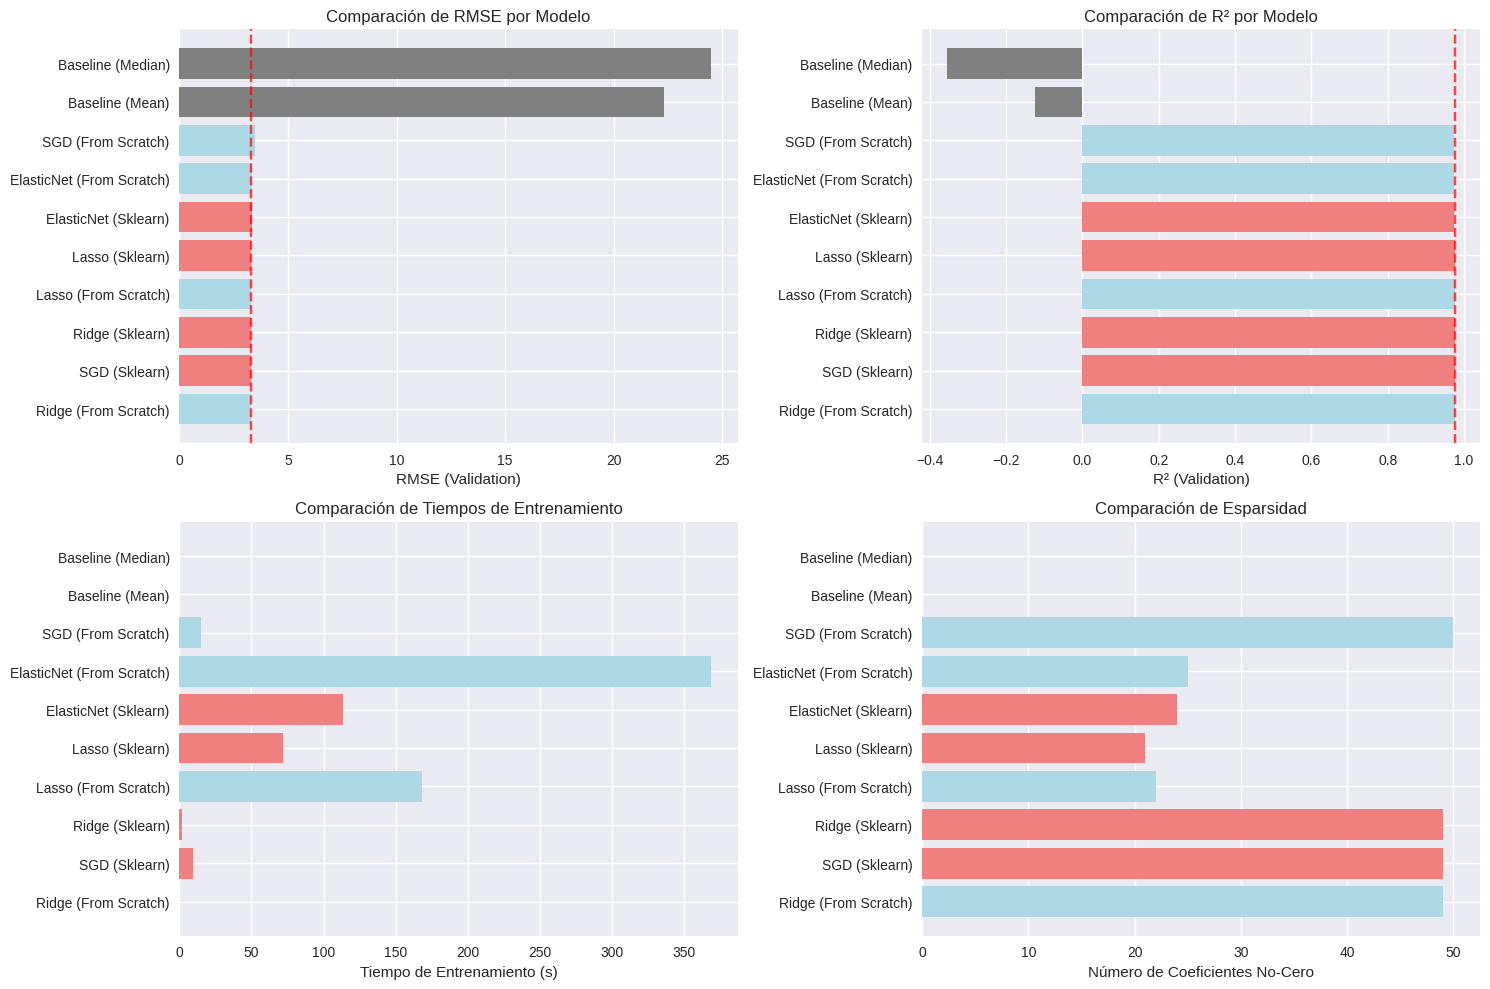

SGD: ΔRMSE Sklearn vs FS = -5.45% (val)
Ridge: ΔRMSE Sklearn vs FS = +0.11% (val)
Lasso: ΔRMSE Sklearn vs FS = +0.21% (val)
ElasticNet: ΔRMSE Sklearn vs FS = -0.50% (val)


In [53]:
def assemble_comparison(best_fs, best_sk, baseline_df):
    rows = []
    # From-scratch
    for name, info in best_fs.items():
        mdl = info['model']
        y_pred_val = mdl.predict(X_val_final)
        rows.append({
            'Model': f"{name} (From Scratch)",
            'Val_RMSE': np.sqrt(mean_squared_error(y_val.values, y_pred_val)),
            'Val_MAE': mean_absolute_error(y_val.values, y_pred_val),
            'Val_R2': r2_score(y_val.values, y_pred_val),
            'Train_Time': info['train_time'],
            'N_Features': int(np.sum(getattr(mdl,'weights', np.ones(X_train_final.shape[1])) != 0)),
            'Type': 'From Scratch',
            'Params': info['params']
        })
    # Sklearn
    for name, info in best_sk.items():
        mdl = info['model']
        y_pred_val = mdl.predict(X_val_final)
        rows.append({
            'Model': f"{name} (Sklearn)",
            'Val_RMSE': np.sqrt(mean_squared_error(y_val.values, y_pred_val)),
            'Val_MAE': mean_absolute_error(y_val.values, y_pred_val),
            'Val_R2': r2_score(y_val.values, y_pred_val),
            'Train_Time': info['train_time'],
            'N_Features': int(np.sum(getattr(mdl, 'coef_', np.ones(X_train_final.shape[1])) != 0)),
            'Type': 'Sklearn',
            'Params': info['params']
        })
    comp = pd.concat([baseline_df, pd.DataFrame(rows)], ignore_index=True).sort_values('Val_RMSE').reset_index(drop=True)
    return comp

comparison_df = assemble_comparison(best_fs, best_sk, baseline_df)

print("\n" + "="*80)
print("COMPARACIÓN COMPLETA (Validation) — con hyperparams")
print("="*80)
print(comparison_df[['Model','Val_RMSE','Val_MAE','Val_R2','Train_Time','N_Features','Type','Params']].round(4))

# Visualización 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
models_plot = comparison_df['Model']
rmse_plot = comparison_df['Val_RMSE']
colors = ['lightblue' if 'From Scratch' in m else ('grey' if 'Baseline' in m else 'lightcoral') for m in models_plot]

axes[0,0].barh(models_plot, rmse_plot, color=colors)
axes[0,0].set_xlabel('RMSE (Validation)')
axes[0,0].set_title('Comparación de RMSE por Modelo')
axes[0,0].axvline(x=comparison_df['Val_RMSE'].min(), color='red', linestyle='--', alpha=0.7)

r2_plot = comparison_df['Val_R2']
axes[0,1].barh(models_plot, r2_plot, color=colors)
axes[0,1].set_xlabel('R² (Validation)')
axes[0,1].set_title('Comparación de R² por Modelo')
axes[0,1].axvline(x=comparison_df['Val_R2'].max(), color='red', linestyle='--', alpha=0.7)

time_plot = comparison_df['Train_Time']
axes[1,0].barh(models_plot, time_plot, color=colors)
axes[1,0].set_xlabel('Tiempo de Entrenamiento (s)')
axes[1,0].set_title('Comparación de Tiempos de Entrenamiento')

features_plot = comparison_df['N_Features']
axes[1,1].barh(models_plot, features_plot, color=colors)
axes[1,1].set_xlabel('Número de Coeficientes No-Cero')
axes[1,1].set_title('Comparación de Esparsidad')

plt.tight_layout()
plt.show()

# Análisis breve 
for base_name in ['SGD','Ridge','Lasso','ElasticNet']:
    fs = comparison_df[comparison_df['Model'].str.startswith(base_name) & comparison_df['Model'].str.contains('From Scratch')]
    sk = comparison_df[comparison_df['Model'].str.startswith(base_name) & comparison_df['Model'].str.contains('Sklearn')]
    if len(fs) and len(sk):
        diff = (sk.iloc[0]['Val_RMSE'] - fs.iloc[0]['Val_RMSE'])/fs.iloc[0]['Val_RMSE']*100
        print(f"{base_name}: ΔRMSE Sklearn vs FS = {diff:+.2f}% (val)")


In [54]:
## Evaluación en test de todos los mdelos

In [55]:
def evaluate_on_test(models_dict, X_te, y_te, label_suffix):
    rows=[]
    for name, info in models_dict.items():
        mdl = info['model']
        y_pred = mdl.predict(X_te)
        rows.append({
            'Model': f"{name} ({label_suffix})",
            'Test_RMSE': np.sqrt(mean_squared_error(y_te, y_pred)),
            'Test_MAE': mean_absolute_error(y_te, y_pred),
            'Test_R2': r2_score(y_te, y_pred),
            'Params': info['params']
        })
    return pd.DataFrame(rows)

# Reentrenar cada "mejor modelo" con Train+Val antes de evaluar en Test
def refit_best_and_eval(best_fs, best_sk, X_tr, y_tr, X_va, y_va, X_te, y_te):
    # concat train+val
    X_tv = np.vstack([X_tr, X_va])
    y_tv = np.concatenate([y_tr.values, y_va.values])
    # refit
    for d in [best_fs, best_sk]:
        for k,info in d.items():
            info['model'].fit(X_tv, y_tv)
    # eval test
    df_fs = evaluate_on_test(best_fs, X_te, y_te.values, 'From Scratch')
    df_sk = evaluate_on_test(best_sk, X_te, y_te.values, 'Sklearn')
    return pd.concat([df_fs, df_sk], ignore_index=True)

test_all = refit_best_and_eval(best_fs, best_sk, X_train_final, y_train, X_val_final, y_val, X_test_final, y_test)

# Añadimos baselines también en TEST
base_rows=[]
for name, const_val in [('Baseline (Mean)', y_train.values.mean()), ('Baseline (Median)', np.median(y_train.values))]:
    y_pred = np.full_like(y_test.values, const_val, dtype=float)
    base_rows.append({
        'Model': name,
        'Test_RMSE': np.sqrt(mean_squared_error(y_test.values, y_pred)),
        'Test_MAE': mean_absolute_error(y_test.values, y_pred),
        'Test_R2': r2_score(y_test.values, y_pred),
        'Params': {}
    })
test_all = pd.concat([pd.DataFrame(base_rows), test_all], ignore_index=True)

print("\n" + "="*80)
print("Métricas en TEST (todos los pipelines re-entrenados con Train+Val)")
print("="*80)
print(test_all.sort_values('Test_RMSE').reset_index(drop=True).round(4))



Métricas en TEST (todos los pipelines re-entrenados con Train+Val)
                       Model  Test_RMSE  Test_MAE  Test_R2  \
0            Ridge (Sklearn)     3.2699    1.9982   0.9759   
1       Ridge (From Scratch)     3.2702    1.9984   0.9759   
2            Lasso (Sklearn)     3.2855    2.0306   0.9757   
3       Lasso (From Scratch)     3.2897    2.0340   0.9756   
4              SGD (Sklearn)     3.3010    2.0024   0.9755   
5       ElasticNet (Sklearn)     3.3013    2.0269   0.9755   
6  ElasticNet (From Scratch)     3.3250    2.0293   0.9751   
7         SGD (From Scratch)     3.4498    2.0397   0.9732   
8            Baseline (Mean)    22.3317   12.5102  -0.1223   
9          Baseline (Median)    24.5007   13.7703  -0.3509   

                                              Params  
0                                    {'alpha': 10.0}  
1                                    {'alpha': 10.0}  
2                                    {'alpha': 0.01}  
3                            

In [56]:
## Selección del mejor modelo y evaluación en test 

In [57]:
def select_and_evaluate_best_model(comparison_df, sklearn_models, from_scratch_models, 
                                  X_train, y_train, X_val, y_val, X_test, y_test):
    """Seleccionar el mejor modelo y evaluar en test"""
    
    # Encontrar el mejor modelo por RMSE en validation
    best_model_row = comparison_df.iloc[0]
    best_model_name = best_model_row['Model']
    best_val_rmse = best_model_row['Val_RMSE']
    
    print(f"MEJOR MODELO SELECCIONADO: {best_model_name}")
    print(f"RMSE en Validation: {best_val_rmse:.4f}")
    
    # Determinar si es from-scratch o sklearn
    if 'From Scratch' in best_model_name:
        model_type = 'from_scratch'
        base_model_name = best_model_name.replace(' (From Scratch)', '')
        best_model = from_scratch_models[base_model_name]
    else:
        model_type = 'sklearn'
        base_model_name = best_model_name.replace(' (Sklearn)', '')
        best_model = sklearn_models[base_model_name]
    
    # Reentrenar con train + validation
    print(f"\nReentrenando {best_model_name} con Train + Validation...")
    
    X_train_val = np.vstack([X_train, X_val])
    y_train_val = np.concatenate([y_train.values, y_val.values])
    
    import time
    start_time = time.time()
    
    if model_type == 'from_scratch':
        best_model.fit(X_train_val, y_train_val)
    else:
        best_model.fit(X_train_val, y_train_val)
    
    re_train_time = time.time() - start_time
    
    # Evaluar en test
    y_pred_test = best_model.predict(X_test)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    
    print(f"\nEVALUACIÓN EN TEST SET:")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")
    print(f"Tiempo de reentrenamiento: {re_train_time:.2f}s")
    
    return best_model, best_model_name, {
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        're_train_time': re_train_time
    }

# Seleccionar y evaluar el mejor modelo
best_model, best_model_name, test_metrics = select_and_evaluate_best_model(
    comparison_df, sklearn_models, from_scratch_models,
    X_train_final, y_train, X_val_final, y_val, X_test_final, y_test
)

MEJOR MODELO SELECCIONADO: Ridge (From Scratch)
RMSE en Validation: 3.2962

Reentrenando Ridge (From Scratch) con Train + Validation...

EVALUACIÓN EN TEST SET:
RMSE: 3.2695
MAE: 1.9979
R²: 0.9759
Tiempo de reentrenamiento: 0.07s


In [58]:
from sklearn.linear_model import LinearRegression

# Calibración post-hoc (lineal) usando VALIDATION
# 1) Obtén predicciones de tu mejor modelo sobre Validation

# Supongamos que 'best_model_sklearn' es tu ganador (e.g., Ridge sklearn) entrenado en Train
best_model_sklearn = Ridge(alpha=10.0, random_state=42).fit(X_train_final, y_train.values)
y_val_pred = best_model_sklearn.predict(X_val_final)
resid_val  = y_val.values - y_val_pred

# 2) Armamos matriz para calibración 
Z_val = np.column_stack([np.ones_like(y_val_pred), y_val_pred, X_val['trip_distance'].values])

calib = LinearRegression().fit(Z_val, resid_val)

# 3) Aplicamos calibración en TEST
#    Reentrena best_model_sklearn en Train+Val 
X_tv = np.vstack([X_train_final, X_val_final])
y_tv = np.concatenate([y_train.values, y_val.values])
best_model_sklearn.fit(X_tv, y_tv)

y_test_pred = best_model_sklearn.predict(X_test_final)
Z_test = np.column_stack([np.ones_like(y_test_pred), y_test_pred, X_test['trip_distance'].values])
resid_correction = calib.predict(Z_test)
y_test_pred_cal = y_test_pred + resid_correction

print("== Métricas Test (sin calibración) ==")
print("RMSE:", np.sqrt(mean_squared_error(y_test.values, y_test_pred)))
print("MAE :", mean_absolute_error(y_test.values, y_test_pred))
print("R²  :", r2_score(y_test.values, y_test_pred))

print("\n== Métricas Test (con calibración post-hoc) ==")
print("RMSE:", np.sqrt(mean_squared_error(y_test.values, y_test_pred_cal)))
print("MAE :", mean_absolute_error(y_test.values, y_test_pred_cal))
print("R²  :", r2_score(y_test.values, y_test_pred_cal))


== Métricas Test (sin calibración) ==
RMSE: 3.2698749896826205
MAE : 1.998167098344939
R²  : 0.9759376196346129

== Métricas Test (con calibración post-hoc) ==
RMSE: 3.2832100032596503
MAE : 1.9396557553626415
R²  : 0.975740959853447



DIAGNÓSTICO DE ERRORES - MEJOR MODELO


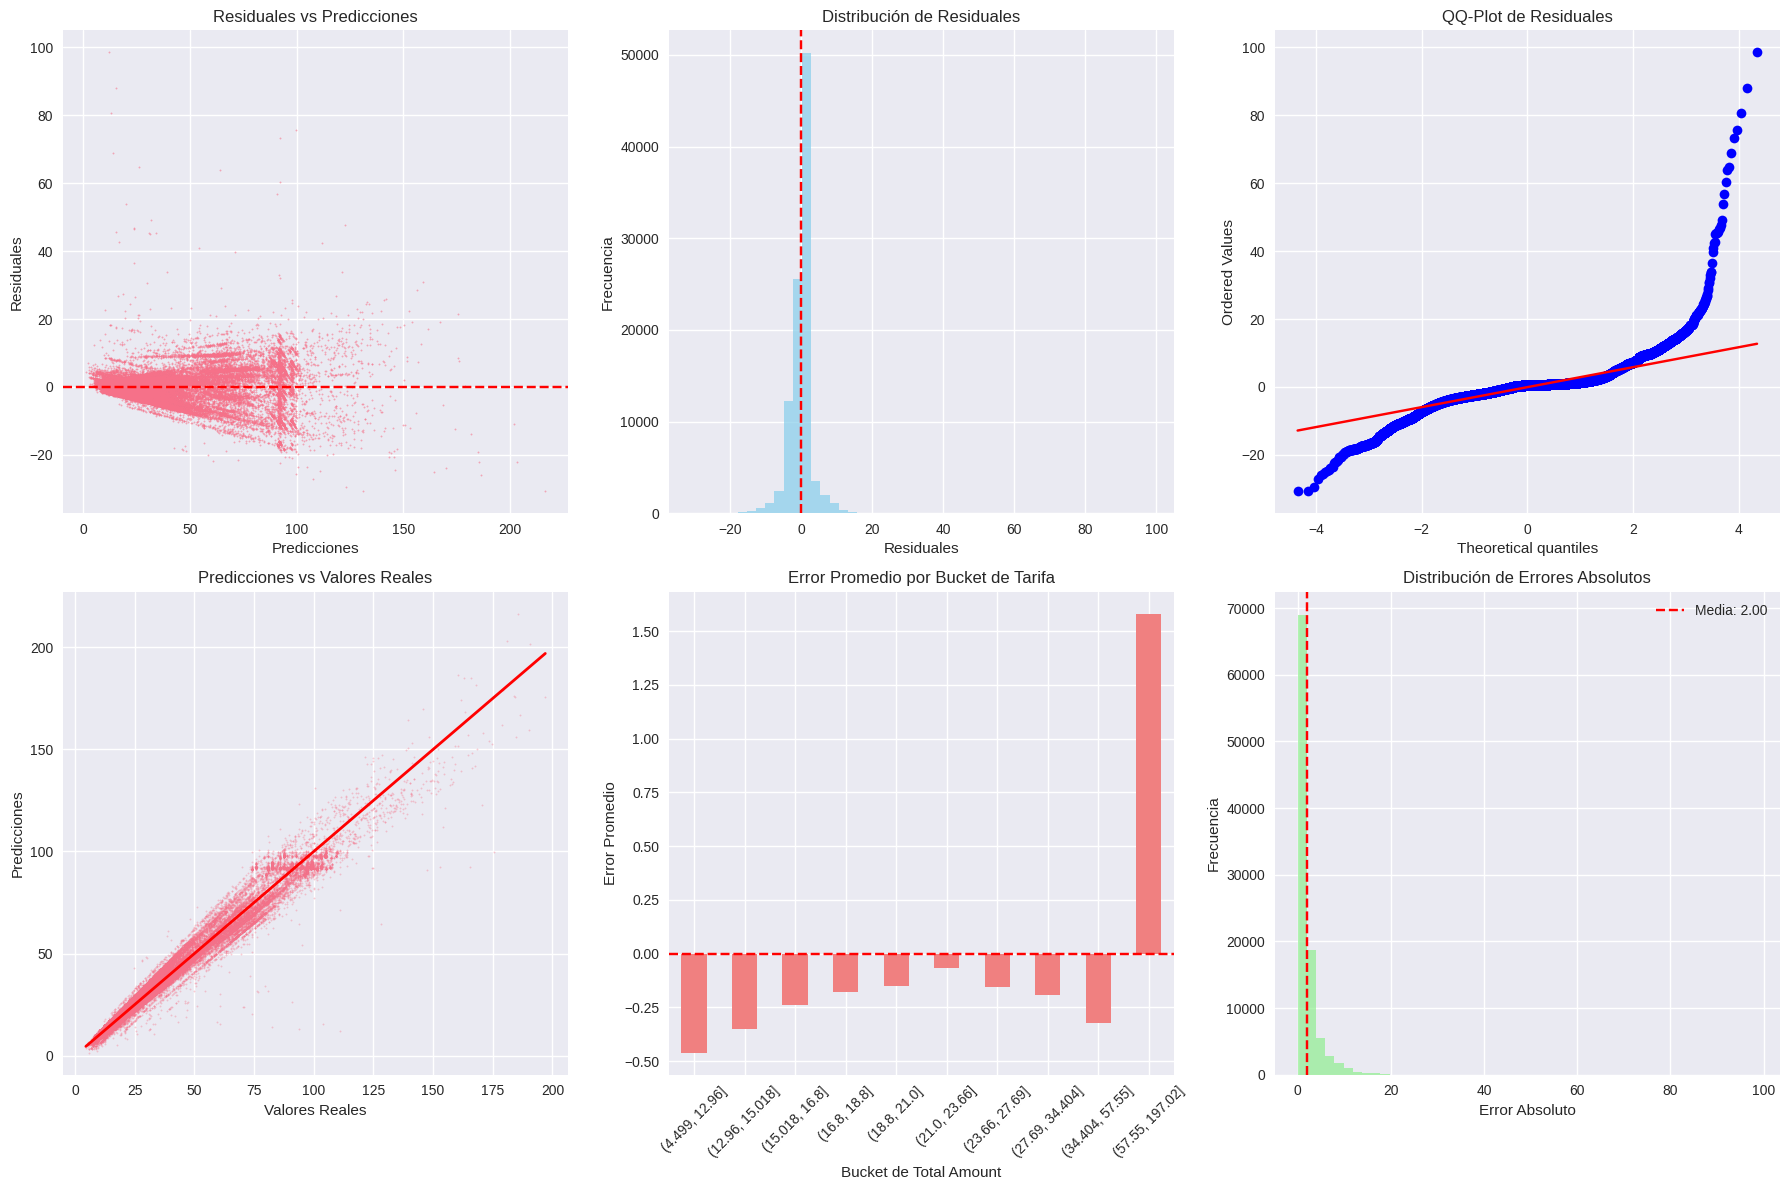


ESTADÍSTICAS DE ERROR DETALLADAS:
Error Absoluto Medio (MAE): 1.9979
Desviación Estándar de Errores: 3.2691
Error Absoluto Mediano: 1.0768
Porcentaje de Errores < $2: 69.47%
Porcentaje de Errores < $5: 91.11%

ERRORES POR BUCKET DE TARIFA:
                residual               
                    mean     std  count
amount_bucket                          
(4.499, 12.96]   -0.4609  1.2259  10233
(12.96, 15.018]  -0.3503  1.2772   9767
(15.018, 16.8]   -0.2393  1.3672  10431
(16.8, 18.8]     -0.1765  1.4880   9597
(18.8, 21.0]     -0.1490  1.6176  10822
(21.0, 23.66]    -0.0679  1.7474   9151
(23.66, 27.69]   -0.1562  2.0477  10004
(27.69, 34.404]  -0.1934  2.5364   9995
(34.404, 57.55]  -0.3216  4.0070  10003
(57.55, 197.02]   1.5810  8.0182   9997


In [59]:
# 11. Diagnóstico de errores y residuales
def error_analysis(best_model, X_test, y_test, best_model_name):
    """Análisis detallado de errores del mejor modelo"""
    
    # Predicciones finales
    y_pred_test = best_model.predict(X_test)
    residuals = y_test - y_pred_test
    
    print("\n" + "="*80)
    print("DIAGNÓSTICO DE ERRORES - MEJOR MODELO")
    print("="*80)
    
    # Gráficos de diagnóstico
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Residuales vs Predicciones
    axes[0,0].scatter(y_pred_test, residuals, alpha=0.5, s=1)
    axes[0,0].axhline(y=0, color='red', linestyle='--')
    axes[0,0].set_xlabel('Predicciones')
    axes[0,0].set_ylabel('Residuales')
    axes[0,0].set_title('Residuales vs Predicciones')
    
    # 2. Distribución de residuales
    axes[0,1].hist(residuals, bins=50, alpha=0.7, color='skyblue')
    axes[0,1].axvline(x=0, color='red', linestyle='--')
    axes[0,1].set_xlabel('Residuales')
    axes[0,1].set_ylabel('Frecuencia')
    axes[0,1].set_title('Distribución de Residuales')
    
    # 3. QQ-Plot para normalidad
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[0,2])
    axes[0,2].set_title('QQ-Plot de Residuales')
    
    # 4. Predicciones vs Valores Reales
    axes[1,0].scatter(y_test, y_pred_test, alpha=0.3, s=1)
    axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', lw=2)
    axes[1,0].set_xlabel('Valores Reales')
    axes[1,0].set_ylabel('Predicciones')
    axes[1,0].set_title('Predicciones vs Valores Reales')
    
    # 5. Errores por buckets de total_amount
    error_df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred_test,
        'residual': residuals
    })
    
    # Crear buckets por percentiles
    error_df['amount_bucket'] = pd.qcut(error_df['actual'], q=10, duplicates='drop')
    bucket_errors = error_df.groupby('amount_bucket').agg({
        'residual': ['mean', 'std', 'count']
    }).round(4)
    
    # Plot errores por bucket
    bucket_errors['residual']['mean'].plot(kind='bar', ax=axes[1,1], color='lightcoral')
    axes[1,1].axhline(y=0, color='red', linestyle='--')
    axes[1,1].set_xlabel('Bucket de Total Amount')
    axes[1,1].set_ylabel('Error Promedio')
    axes[1,1].set_title('Error Promedio por Bucket de Tarifa')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. Distribución de errores absolutos
    absolute_errors = np.abs(residuals)
    axes[1,2].hist(absolute_errors, bins=50, alpha=0.7, color='lightgreen')
    axes[1,2].axvline(x=absolute_errors.mean(), color='red', linestyle='--', label=f'Media: {absolute_errors.mean():.2f}')
    axes[1,2].set_xlabel('Error Absoluto')
    axes[1,2].set_ylabel('Frecuencia')
    axes[1,2].set_title('Distribución de Errores Absolutos')
    axes[1,2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Métricas de error adicionales
    print("\nESTADÍSTICAS DE ERROR DETALLADAS:")
    print(f"Error Absoluto Medio (MAE): {np.mean(absolute_errors):.4f}")
    print(f"Desviación Estándar de Errores: {np.std(residuals):.4f}")
    print(f"Error Absoluto Mediano: {np.median(absolute_errors):.4f}")
    print(f"Porcentaje de Errores < $2: {(absolute_errors < 2).mean()*100:.2f}%")
    print(f"Porcentaje de Errores < $5: {(absolute_errors < 5).mean()*100:.2f}%")
    
    return error_df, bucket_errors

# Realizar análisis de errores
error_df, bucket_errors = error_analysis(best_model, X_test_final, y_test, best_model_name)

print("\nERRORES POR BUCKET DE TARIFA:")
print(bucket_errors)

In [60]:
# 12. Conclusiones y recomendaciones
def generate_final_conclusions(comparison_df, test_metrics, best_model_name, error_df):
    """Generar conclusiones finales del proyecto"""
    
    print("\n" + "="*80)
    print("CONCLUSIONES FINALES")
    print("="*80)
    
    # Resumen de performance
    best_val_rmse = comparison_df.iloc[0]['Val_RMSE']
    best_test_rmse = test_metrics['test_rmse']
    
    print(f"MODELO GANADOR: {best_model_name}")
    print(f"RMSE Validation: ${best_val_rmse:.2f}")
    print(f"RMSE Test: ${best_test_rmse:.2f}")
    print(f"R² Test: {test_metrics['test_r2']:.4f}")
    
    # Análisis de sobreajuste
    overfitting_gap = best_test_rmse - best_val_rmse
    overfitting_pct = (overfitting_gap / best_val_rmse) * 100
    
    print(f"\nANÁLISIS DE SOBREAJUSTE:")
    print(f"Diferencia Test-Validation: ${overfitting_gap:.2f} ({overfitting_pct:+.1f}%)")
    

    # Comparación with-scratch vs sklearn
    fs_models = comparison_df[comparison_df['Type'] == 'From Scratch']
    sk_models = comparison_df[comparison_df['Type'] == 'Sklearn']
    
    avg_fs_rmse = fs_models['Val_RMSE'].mean()
    avg_sk_rmse = sk_models['Val_RMSE'].mean()
    
    print(f"\nCOMPARACIÓN FROM-SCRATCH vs SKLEARN:")
    print(f"RMSE Promedio From-Scratch: ${avg_fs_rmse:.2f}")
    print(f"RMSE Promedio Sklearn: ${avg_sk_rmse:.2f}")
    print(f"Diferencia: ${(avg_sk_rmse - avg_fs_rmse):.2f}")
    
    # Análisis de errores
    absolute_errors = np.abs(error_df['residual'])
    print(f"\nDISTRIBUCIÓN DE ERRORES:")
    print(f"68% de viajes tienen error < ${np.percentile(absolute_errors, 68):.2f}")
    print(f"95% de viajes tienen error < ${np.percentile(absolute_errors, 95):.2f}")
    
    # Recomendaciones operativas
    print(f"\nRECOMENDACIONES OPERATIVAS:")
    print("1. El modelo puede estimar tarifas con error promedio de ${:.2f}".format(absolute_errors.mean()))
    print("2. Para el {}% de viajes, el error es menor a $5".format((absolute_errors < 5).mean()*100))
    

# Generar conclusiones finales
generate_final_conclusions(comparison_df, test_metrics, best_model_name, error_df)


CONCLUSIONES FINALES
MODELO GANADOR: Ridge (From Scratch)
RMSE Validation: $3.30
RMSE Test: $3.27
R² Test: 0.9759

ANÁLISIS DE SOBREAJUSTE:
Diferencia Test-Validation: $-0.03 (-0.8%)

COMPARACIÓN FROM-SCRATCH vs SKLEARN:
RMSE Promedio From-Scratch: $3.36
RMSE Promedio Sklearn: $3.31
Diferencia: $-0.05

DISTRIBUCIÓN DE ERRORES:
68% de viajes tienen error < $1.91
95% de viajes tienen error < $6.97

RECOMENDACIONES OPERATIVAS:
1. El modelo puede estimar tarifas con error promedio de $2.00
2. Para el 91.106% de viajes, el error es menor a $5


In [61]:
# Guardar resultados finales
def save_final_results(comparison_df, test_metrics, best_model_name, error_df):
    """Guardar todos los resultados para el reporte"""
    
    results = {
        'comparison_table': comparison_df,
        'test_metrics': test_metrics,
        'best_model': best_model_name,
        'error_analysis': error_df.describe(),
        'timestamp': pd.Timestamp.now()
    }
    
    # Guardar como CSV
    comparison_df.to_csv('model_comparison_results.csv', index=False)
    error_df.to_csv('error_analysis_results.csv', index=False)
    
    # Guardar métricas de test
    test_metrics_df = pd.DataFrame([test_metrics])
    test_metrics_df.to_csv('test_metrics_results.csv', index=False)
    
    print("\n Resultados guardados en:")
    print("   - model_comparison_results.csv")
    print("   - error_analysis_results.csv") 
    print("   - test_metrics_results.csv")

save_final_results(comparison_df, test_metrics, best_model_name, error_df)


 Resultados guardados en:
   - model_comparison_results.csv
   - error_analysis_results.csv
   - test_metrics_results.csv


Modelo ganador: Ridge (From Scratch)

== Métricas en SUBSET de Test (n=20) ==
RMSE: 3.0916 | MAE: 2.2074 | R²: 0.9765

== Métricas en TEST COMPLETO (n=100000) ==
RMSE: 3.2695 | MAE: 1.9979 | R²: 0.9759

Muestra de predicciones (subset):
 actual  pred  resid
  24.80 29.14  -4.34
  20.02 21.13  -1.11
  50.30 41.59   8.71
  17.05 17.70  -0.65
  36.60 35.22   1.38
  16.11 18.68  -2.57
  17.16 16.35   0.81
  53.76 51.85   1.91
  13.10 11.98   1.12
  13.12 12.35   0.77
  24.90 29.09  -4.19
  12.20 13.05  -0.85
  15.85 13.99   1.86
  98.88 92.03   6.85
  24.00 23.34   0.66
  16.50 17.40  -0.90
  16.80 19.39  -2.59
  14.55 12.91   1.64
  18.45 17.94   0.51
  18.96 18.24   0.72


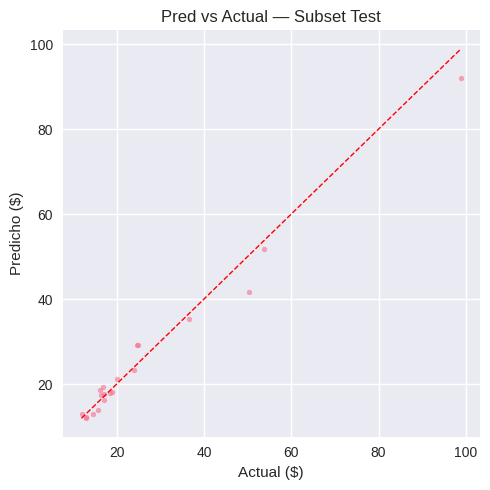

In [63]:
# 13. Predicción de prueba y verificación rápida de RMSE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Asegurar que 'best_model' está entrenado (viene de select_and_evaluate_best_model).
try:
    _ = best_model.predict(X_test_final[:1])
    winner_name = best_model_name
except Exception:
    winner_name = comparison_df.iloc[0]['Model']
    if 'From Scratch' in winner_name:
        key = winner_name.replace(' (From Scratch)', '')
        mdl = best_fs[key]['model']
    else:
        key = winner_name.replace(' (Sklearn)', '')
        mdl = best_sk[key]['model']
    # Reentrenar con Train+Val para evaluación en Test
    X_tv = np.vstack([X_train_final, X_val_final])
    y_tv = np.concatenate([y_train.values, y_val.values])
    mdl.fit(X_tv, y_tv)
    best_model = mdl
    best_model_name = winner_name

print(f"Modelo ganador: {best_model_name}")

# --- Subset reproducible de TEST (20 muestras o menos si el test es más pequeño)
np.random.seed(42)
n_subset = min(20, X_test_final.shape[0])
idx = np.random.choice(X_test_final.shape[0], size=n_subset, replace=False)

y_true_sub = y_test.values[idx]
y_pred_sub = best_model.predict(X_test_final[idx])

# Métricas en subset
rmse_sub = np.sqrt(mean_squared_error(y_true_sub, y_pred_sub))
mae_sub  = mean_absolute_error(y_true_sub, y_pred_sub)
r2_sub   = r2_score(y_true_sub, y_pred_sub)

# Métricas en TODO el TEST (confirmación del RMSE global)
y_pred_full = best_model.predict(X_test_final)
rmse_full = np.sqrt(mean_squared_error(y_test.values, y_pred_full))
mae_full  = mean_absolute_error(y_test.values, y_pred_full)
r2_full   = r2_score(y_test.values, y_pred_full)

print(f"\n== Métricas en SUBSET de Test (n={n_subset}) ==")
print(f"RMSE: {rmse_sub:.4f} | MAE: {mae_sub:.4f} | R²: {r2_sub:.4f}")

print(f"\n== Métricas en TEST COMPLETO (n={X_test_final.shape[0]}) ==")
print(f"RMSE: {rmse_full:.4f} | MAE: {mae_full:.4f} | R²: {r2_full:.4f}")

# Preview de predicciones
preview = pd.DataFrame({
    'actual':  y_true_sub.round(2),
    'pred':    y_pred_sub.round(2),
    'resid':  (y_true_sub - y_pred_sub).round(2)
})
print("\nMuestra de predicciones (subset):")
print(preview.to_string(index=False))

# Scatter rápido Pred vs Actual (subset)
plt.figure(figsize=(5,5))
plt.scatter(y_true_sub, y_pred_sub, s=12, alpha=0.6)
mn, mx = min(y_true_sub.min(), y_pred_sub.min()), max(y_true_sub.max(), y_pred_sub.max())
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
plt.xlabel('Actual ($)')
plt.ylabel('Predicho ($)')
plt.title('Pred vs Actual — Subset Test')
plt.tight_layout()
plt.show()
